# Economic damages from changing mean temperatures and variability, and other types of Tx5d damages
#### Christopher Callahan
#### Christopher.W.Callahan.GR@dartmouth.edu

#### Mechanics
Dependencies

In [1]:
import xarray as xr
import numpy as np
import sys
import os
import datetime
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
import matplotlib.colors as colors
import matplotlib.gridspec as gridspec
import seaborn as sns
from rasterio import features
from affine import Affine
import geopandas as gp
import descartes
import cartopy as cart
import cartopy.crs as ccrs
from cartopy.feature import ShapelyFeature
from scipy import stats

Data location

In [2]:
loc_damages = "../Data/Damages/"
loc_shp = "../Data/Shapefile/"
loc_panel = "../Data/Panel/"

Years

In [3]:
y1 = 1993
y2 = 2013
yrs = np.arange(y1,y2+1,1)
nyrs = len(yrs)

Shapefile

In [4]:
shp = gp.read_file(loc_shp+"gadm36_1.shp")
shp = shp.rename(columns={"GID_1":"region"})

#### Analysis

Damages for Tx without changing mean temperatures

In [5]:
smth = 15
extr = "tx5d"
damages_tx_constant_t = xr.open_dataset(loc_damages+"CMIP6_historical_region_"+extr+"_income_damages_constant_temp_smooth"+str(smth)+"_"+str(y1)+"-"+str(y2)+".nc")

Plot

/dartfs-hpc/rc/home/y/f003k8y/.conda/envs/ccallahan/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


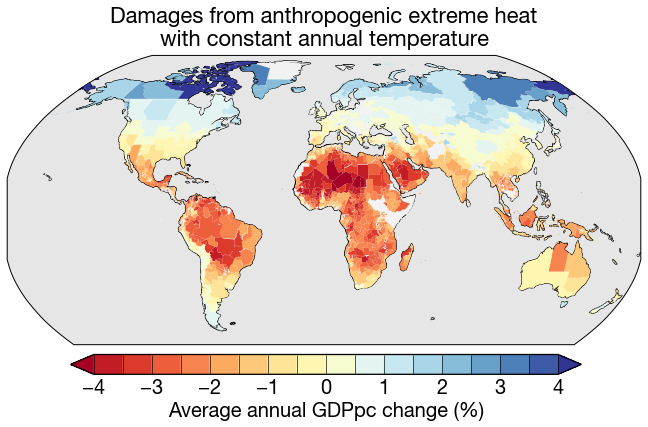

In [10]:
fig = plt.figure(figsize=(11,11))
rcParams["font.family"] = "sans-serif"
rcParams["font.sans-serif"] = ["Helvetica Neue"]
rcParams["font.size"] = 20.0
rcParams["axes.linewidth"] = 1.3
rcParams['xtick.major.size'] = 8
rcParams['xtick.major.width'] = 1.3
rcParams['ytick.major.size'] = 8
rcParams['ytick.major.width'] = 1.3
rcParams["mathtext.default"] = "regular"

tfs = 22

## map on top
gs1 = gridspec.GridSpec(1,1)
gs1.update(left=0.12,right=0.92,top=0.9,bottom=0.1,wspace=0.23,hspace=0.3)

ax = plt.subplot(gs1[0,0],projection=ccrs.Robinson())
ax.set_extent([-180,180,-63,90],crs=ccrs.PlateCarree())
ax.coastlines(linewidth=0.4)
ax.add_feature(cart.feature.OCEAN, edgecolor="white",facecolor=[0.9,0.9,0.9])
ax.add_feature(cart.feature.LAND, edgecolor="black",facecolor=[0.98,0.98,0.98])

# set colors
vals = damages_tx_constant_t.gpc_change_pct_mean.mean(dim="time")
vmin = -4
vmax = 4
ncol = 17
cmapname = 'RdYlBu'

bounds = np.linspace(vmin,vmax,ncol)
cols = plt.get_cmap(cmapname)(np.linspace(0,1,len(bounds)+1))
cm = colors.ListedColormap(cols[1:-1])
cm.set_over(cols[-1])
cm.set_under(cols[0])
norm = colors.Normalize(vmin=vmin,vmax=vmax)
cbar = plt.cm.ScalarMappable(norm=norm,cmap=cm)

h = ""

# add geometries
baseline_col = [0.95,0.95,0.95]
for i in shp.region:
    geom = shp.loc[shp.region==i,"geometry"]
    if i in vals.region.values:
        val = vals.loc[i].values
                
        if (~np.isnan(val)):
            ax.add_geometries(geom,ccrs.PlateCarree(),facecolor=cbar.to_rgba(val),
                                  edgecolor="black",linewidth=0,zorder=10)
        else:
            ax.add_geometries(geom,ccrs.PlateCarree(),facecolor=baseline_col,
                                  edgecolor="black",linewidth=0)
    else:
        ax.add_geometries(geom,ccrs.PlateCarree(),facecolor=baseline_col,
                                  edgecolor="black",linewidth=0)


plt.title("Damages from anthropogenic extreme heat"+"\n"+"with constant annual temperature",pad=10,fontsize=tfs)

l = 0.2
b = 0.28
w = 0.645
h = 0.025

cbar_ax = fig.add_axes([l,b,w,h])
cb = fig.colorbar(cbar,cax=cbar_ax,orientation="horizontal",
                              drawedges=True,extend="both")
cbar_ax.tick_params(direction="in",width=0.05)
cb.set_label("Average annual GDPpc change (%)")


plt.savefig("../Figures/FigX_Tx_Damages_ConstantT.png")
plt.show()

Read damages

In [6]:
extr = "tx5d"
smth = 15
damages_tx = xr.open_dataset(loc_damages+"CMIP6_historical_region_"+extr+"_income_damages_smooth"+str(smth)+"_"+str(y1)+"-"+str(y2)+".nc")
damages_t = xr.open_dataset(loc_damages+"CMIP6_historical_region_temperature_income_damages_"+extr+"_model_smooth"+str(smth)+"_"+str(y1)+"-"+str(y2)+".nc")
damages_tvar = xr.open_dataset(loc_damages+"CMIP6_historical_region_variability_income_damages_"+extr+"_model_smooth"+str(smth)+"_"+str(y1)+"-"+str(y2)+".nc")
damages_all = xr.open_dataset(loc_damages+"CMIP6_historical_region_allvariables_income_damages_"+extr+"_model_smooth"+str(smth)+"_"+str(y1)+"-"+str(y2)+".nc")
obs_gpc = damages_t.obs_gpc_mean
yr_gpc = 2010
obs_gpc_yr = obs_gpc.loc[:,yr_gpc]

In [7]:
x1 = damages_t.gpc_change_pct_mean.mean(dim="time")
x2 = damages_tvar.gpc_change_pct_mean.mean(dim="time")

/dartfs-hpc/rc/home/y/f003k8y/.conda/envs/ccallahan/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


In [8]:
ind = np.abs(x1)<100

Plot GDPpc change per year

In [9]:
damages_tvar_exists = (~np.isnan(damages_tvar.gpc_change_pct_mean.mean(dim="time"))).astype(int)

/dartfs-hpc/rc/home/y/f003k8y/.conda/envs/ccallahan/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/dartfs-hpc/rc/home/y/f003k8y/.conda/envs/ccallahan/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/dartfs-hpc/rc/home/y/f003k8y/.conda/envs/ccallahan/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


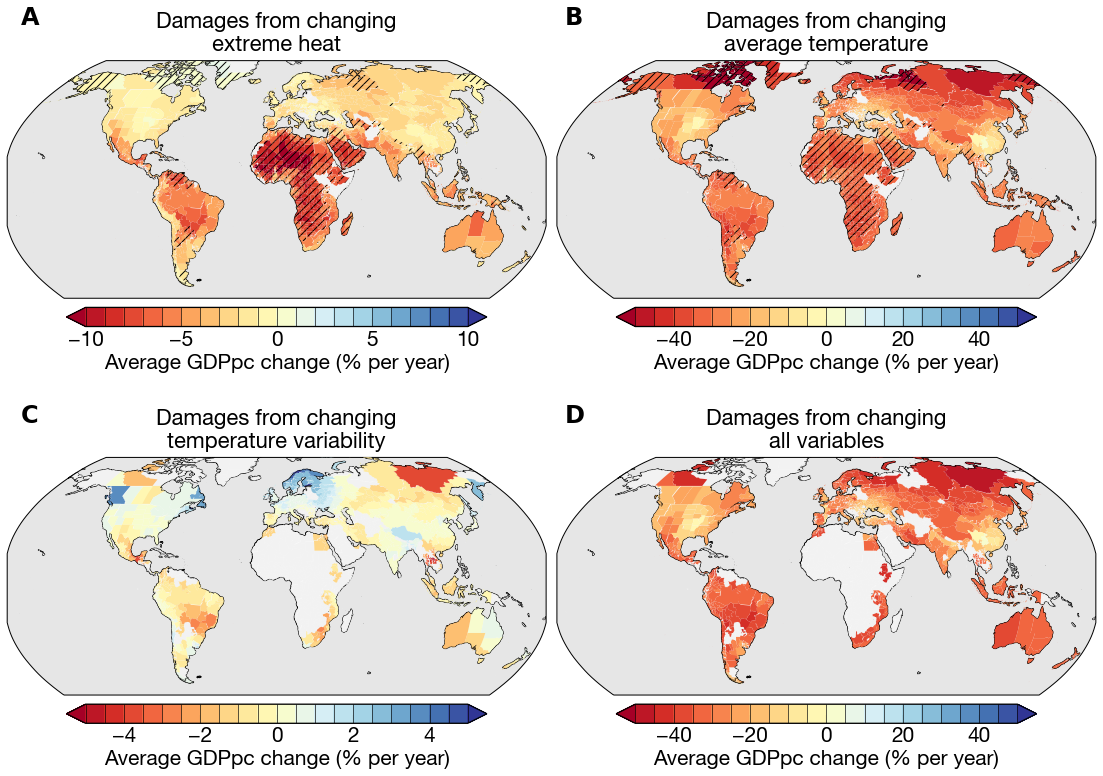

In [10]:
fig = plt.figure(figsize=(18,13))
rcParams["font.family"] = "sans-serif"
rcParams["font.sans-serif"] = ["Helvetica Neue"]
rcParams["font.size"] = 21.0
rcParams["axes.linewidth"] = 1.3
rcParams['xtick.major.size'] = 8
rcParams['xtick.major.width'] = 1.3
rcParams['ytick.major.size'] = 8
rcParams['ytick.major.width'] = 1.3

gs2 = gridspec.GridSpec(2,2)
gs2.update(left=0.12,right=0.96,top=0.9,bottom=0.15,wspace=0.02,hspace=0.3)

## now map

for j in np.arange(0,4,1):
    ax = plt.subplot(gs2[j],projection=ccrs.Robinson())
    ax.set_extent([-180,180,-63,80],crs=ccrs.PlateCarree())
    ax.coastlines(linewidth=0.4)
    ax.add_feature(cart.feature.OCEAN, edgecolor="white",facecolor=[0.9,0.9,0.9])
    ax.add_feature(cart.feature.LAND, edgecolor="black",facecolor=[0.98,0.98,0.98])

    # set colors
    if j == 0:
        # extremes
        vmin = -10
        vmax = 10
        ncol = 21 # choose a number greater than
                  # the number of colors you actually want
        vals = damages_tx.gpc_change_pct_mean.mean(dim="time")
    elif j == 1:
        # average T
        vmin = -50
        vmax = 50
        ncol = 21
        vals = damages_t.gpc_change_pct_mean.mean(dim="time")
    elif j == 2:
        # variability
        vmin = -5
        vmax = 5
        ncol = 21
        vals = damages_tvar.gpc_change_pct_mean.mean(dim="time")
    elif j == 3:
        # all 
        vmin = -50
        vmax = 50
        ncol = 21
        vals = damages_all.gpc_change_pct_mean.mean(dim="time")
    bounds = np.linspace(vmin,vmax,ncol)
    cmapname = 'RdYlBu'
    cols = plt.get_cmap(cmapname)(np.linspace(0,1,len(bounds)+1))
    cm = colors.ListedColormap(cols[1:-1])
    cm.set_over(cols[-1])
    cm.set_under(cols[0])
    norm = colors.Normalize(vmin=vmin,vmax=vmax)
    cbar = plt.cm.ScalarMappable(norm=norm,cmap=cm)

    
    # plot geoms
    baseline_col = [0.95,0.95,0.95]
                   
    if j <= 1:
        ## hatching optional
        for i in shp.region:
            geom = shp.loc[shp.region==i,"geometry"]
            if i in vals.region.values:
                val = vals.loc[i]
                col = cbar.to_rgba(val)
                if (~np.isnan(val))&(damages_tvar_exists.loc[i].values==1.0):
                    ax.add_geometries(geom,ccrs.PlateCarree(),facecolor=col,
                                                 edgecolor="black",linewidth=0,zorder=10)
                elif (~np.isnan(val))&(damages_tvar_exists.loc[i].values==0.0):
                    ax.add_geometries(geom,ccrs.PlateCarree(),facecolor=col,
                                                 edgecolor="black",linewidth=0,
                                      hatch="///",zorder=10)
                else:
                    ax.add_geometries(geom,ccrs.PlateCarree(),facecolor=baseline_col,
                                                 edgecolor="black",linewidth=0)
            else:
                ax.add_geometries(geom,ccrs.PlateCarree(),facecolor=baseline_col,
                                  edgecolor="black",linewidth=0)
    else:
        # no hatching
        for i in shp.region:
            geom = shp.loc[shp.region==i,"geometry"]
            if i in vals.region.values:
                val = vals.loc[i]
                col = cbar.to_rgba(val)
                if (~np.isnan(val)):
                    ax.add_geometries(geom,ccrs.PlateCarree(),facecolor=col,
                                                 edgecolor="black",linewidth=0,zorder=10)
                else:
                    ax.add_geometries(geom,ccrs.PlateCarree(),facecolor=baseline_col,
                                                 edgecolor="black",linewidth=0)
            else:
                ax.add_geometries(geom,ccrs.PlateCarree(),facecolor=baseline_col,
                                  edgecolor="black",linewidth=0)
    
    # colorbar and title
    tfs = 22
    b = 0.325
    w = 0.325
    h = 0.027
    if j == 0:
        plt.title("Damages from changing"+"\n"+"extreme heat",pad=10,fontsize=tfs)
    if j == 1:
        l = 0.165
        plt.title("Damages from changing"+"\n"+"average temperature",pad=10,fontsize=tfs)
        #tks = [0,2,4,6,8,10]
    elif j == 2:
        l = 0.59
        plt.title("Damages from changing"+"\n"+"temperature variability",pad=10,fontsize=tfs)
        #tks = [0,0.1,0.2,0.3,0.4]
    elif j == 3:
        l = 0.59
        plt.title("Damages from changing"+"\n"+"all variables",pad=10,fontsize=tfs)
    
    #cbar_ax = fig.add_axes([l,b,w,h])
    
    # colorbar
    xt = "both"
    cb = fig.colorbar(cbar,orientation="horizontal",extend=xt,
                     shrink=0.78,aspect=20,pad=0.03,drawedges=True)
    cb.ax.tick_params(direction="in",width=0.05)
    cb.set_label("Average GDPpc change (% per year)")


plt.figtext(0.13,0.925,r"$\bf{A}$",fontsize=24)
plt.figtext(0.55,0.925,r"$\bf{B}$",fontsize=24)
plt.figtext(0.13,0.5,r"$\bf{C}$",fontsize=24)
plt.figtext(0.55,0.5,r"$\bf{D}$",fontsize=24)

plt.savefig("../Figures/FigX_Other_Damages.png")
plt.show()

In [11]:
x = damages_all.gpc_change_pct_mean.mean(dim="time")

/dartfs-hpc/rc/home/y/f003k8y/.conda/envs/ccallahan/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


In [28]:
# USA.45_1

In [12]:
tx_frac = 100*damages_tx.gpc_change_pct_mean.mean(dim="time")/damages_all.gpc_change_pct_mean.mean(dim="time")

In [13]:
np.nanmean(tx_frac)

9.76062316524898

In [14]:
100*(5/365.)

1.36986301369863